# Phân loại văn bản báo tiếng việt

## Import các thư viện cần dùng

In [1]:
import json
import requests
from pprint import pprint
import re
import string
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict
import warnings
import sys
import torch

In [2]:
# Kiểm tra GPU có khả dụng không
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cpu':
    raise RuntimeError("No GPU found")

print(f'Using device: {device}')

Using device: cuda


In [3]:
# Đặt random seed
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

## Tiền sử lý dữ liệu

### Tải file json chứa dữ liệu

In [4]:
# URL trực tiếp đến file JSON thô trên GitHub
url = 'https://raw.githubusercontent.com/letangphuquy/AI4E/master/3-ml-crawler/data/news_final.json'

# Tải nội dung của file
response = requests.get(url)

# Kiểm tra mã trạng thái phản hồi để đảm bảo rằng yêu cầu thành công
if response.status_code == 200:
    try:
        data = response.json()  # Đọc nội dung file JSON

        # Hiển thị phần tử đầu tiên của file JSON
        if isinstance(data, list) and len(data) > 0:
            pprint(json.dumps(data[0], indent=4, ensure_ascii=False))
        else:
            print("Dữ liệu JSON không phải là một danh sách hoặc danh sách trống.")

    except json.JSONDecodeError as e:
        print("JSONDecodeError: Không thể phân tích nội dung JSON.")
        print("Nội dung phản hồi không phải là JSON hợp lệ:")
        print(response.text)  # In ra nội dung phản hồi để kiểm tra
else:
    print(f"Yêu cầu thất bại với mã trạng thái {response.status_code}")
    print("Nội dung phản hồi:", response.text)

('{\n'
 '    "url": '
 '"https://dantri.com.vn/xa-hoi/thu-tuong-kiem-soat-quyen-luc-trong-xay-dung-va-thuc-thi-phap-luat-20240730132720264.htm",\n'
 '    "title": "Thủ tướng: \\"Kiểm soát quyền lực trong xây dựng và thực thi '
 'pháp luật\\"",\n'
 '    "description": "Theo yêu cầu của Thủ tướng Phạm Minh Chính, các cơ quan '
 'cần phối hợp tạo lập cơ chế vận hành, kiểm soát có hiệu quả, phòng ngừa rủi '
 'ro và kiểm soát quyền lực trong xây dựng, thực thi pháp luật.",\n'
 '    "content": "Yêu cầu này được Thủ tướng Phạm Minh Chính nhấn mạnh khi '
 'phát biểu kết luận Hội nghị trực tuyến toàn quốc quán triệt triển khai một '
 'số Luật, Nghị quyết được Quốc hội tại kỳ họp thứ 7, sáng 30/7. Hội nghị do '
 'Chính phủ phối hợp Ủy ban Thường vụ Quốc hội và các cơ quan liên quan tổ '
 'chức.\\nThủ tướng Phạm Minh Chính nhấn mạnh xây dựng và hoàn thiện thể chế '
 'là một trong 3 đột phá chiến lược, chủ trương lớn của Đảng.\\nTheo ông, thể '
 'chế phù hợp sẽ tạo động lực phát triển, góp phần nâ

### Xem các đầu mục

In [5]:
# Trích xuất các danh mục (categories)
categories = {}
for article in data:
    cat = article['metadata']['cat']
    if not cat in categories:
        categories[cat] = {'cnt': 0, 'subcat': set()}
    categories[cat]['cnt'] += 1
    categories[cat]['subcat'].add(article['metadata']['subcat'])

for category, info in categories.items():
    print(f"Category: {category}, Count: {info}")

Category: Xã hội, Count: {'cnt': 328, 'subcat': {'', 'Cuộc đời và sự nghiệp của Tổng Bí thư Nguyễn Phú Trọng', 'Giao thông', 'Chuyện ngày mới', 'Nóng trên mạng', 'Môi trường', 'Chính trị', 'Học tập Bác'}}
Category: Số hóa, Count: {'cnt': 386, 'subcat': {'Tech Awards 2024', 'Sản phẩm', 'Blockchain', 'Công nghệ', 'Kinh nghiệm', 'Data4life 2024', 'Ngày hội Game Việt Nam 2024', None}}
Category: Du lịch, Count: {'cnt': 1142, 'subcat': {'', 'Điểm đến', 'Khám phá', 'Ăn ăn uống uống', 'Ảnh', 'Đi đâu chơi đi', 'Tour hay - Khuyến mại', 'Video - Ảnh', 'Ẩm thực', 'Khám phá mùa hè Malaysia', 'Ngủ ngủ nghỉ nghỉ', 'Món ngon - Điểm đẹp', 'Dấu chân', 'Tư vấn', 'Tin tức'}}
Category: Chính trị, Count: {'cnt': 382, 'subcat': {'', 'Sự kiện', 'Xây dựng đảng', 'Đối ngoại'}}
Category: Bạn đọc, Count: {'cnt': 376, 'subcat': {'', 'Bạn đọc nói', 'Thơ', 'Hồi âm', 'Chia sẻ'}}
Category: Nội dung chuyên đề, Count: {'cnt': 404, 'subcat': {''}}
Category: Kinh doanh, Count: {'cnt': 1402, 'subcat': {'', 'Tài chính',

### Chuyển đổi đầu mục

Filtered articles count: 17897


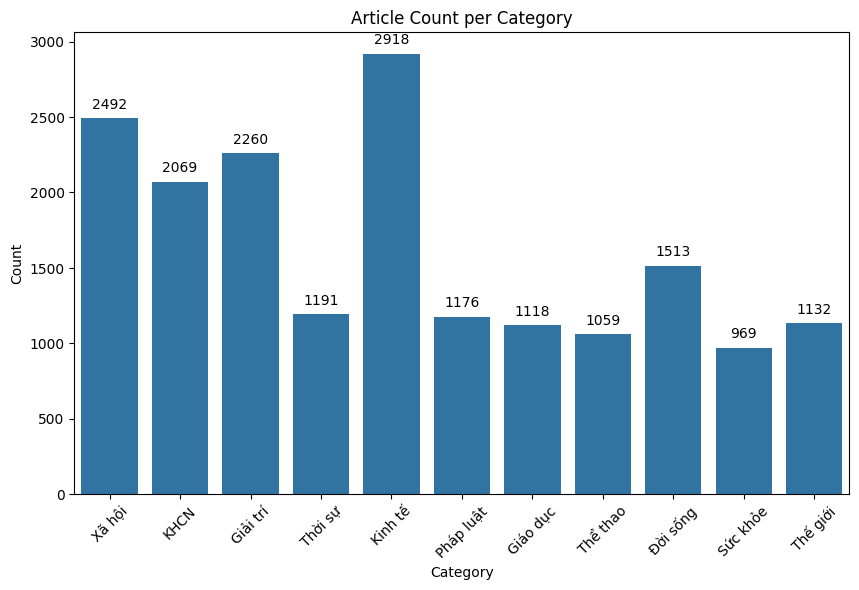

In [6]:
# Từ điển ánh xạ các categories hiện tại về 12 loại
# Một số category khá "broad" do hiện tượng mất cân bằng dữ liệu
categories_include = {
    "Thời sự": ["Chính trị", "Tuần Việt Nam"],
    "Pháp luật": [],
    "Thế giới": [],
    "Kinh tế": ["Kinh doanh", "Bất động sản", "Thị trường tiêu dùng", "Việc làm"],
    "Xã hội": ["Văn hóa", "Dân tộc - tôn giáo", "Nông thôn mới", "Dân tộc thiểu số và miền núi", "Nội dung chuyên đề", "An sinh"],
    "Giáo dục": [],
    "Sức khỏe": [], # Sức khỏe - Y tế
    "Đời sống": ["Bảo vệ người tiêu dùng", "Nhân ái", "Tình yêu"],
    "KHCN": ["Thông tin và truyền thông", "Công nghiệp hỗ trợ", "Khoa học", "Sức mạnh số", "Số hóa", "Khoa học - công nghệ"],
    "Thể thao": [],
    "Giải trí": ["Du lịch"]
}

# Lọc và chuyển đổi categories
filtered_data = []
for article in data:
    old_category = article['metadata']['cat']
    if old_category not in categories_include:
        new_category = ""
        for category, subcategories in categories_include.items():
            flag = False
            for subcat in subcategories:
                if subcat in old_category: flag = True; new_category = category
            if flag: break
        if not new_category: continue
        article['metadata']['cat'] = new_category
        filtered_data.append(article)
    else: filtered_data.append(article)

# In ra các bài báo sau khi lọc và chuyển đổi categories
print(f"Filtered articles count: {len(filtered_data)}")
# Trích xuất các danh mục (categories)
categories = [article['metadata']['cat'] for article in filtered_data]

# Đếm số lượng từng danh mục
category_counts = {}
for category in categories:
    if category in category_counts:
        category_counts[category] += 1
    else:
        category_counts[category] = 1

# Vẽ biểu đồ cột
plt.figure(figsize=(10, 6))  # Điều chỉnh kích thước biểu đồ nhỏ hơn
ax = sns.barplot(x=list(category_counts.keys()), y=list(category_counts.values()))
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Article Count per Category')
plt.xticks(rotation=45)

# Thêm số lượng ở trên mỗi cột
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.savefig('category-distribution.png')
plt.show()

Filtered articles to use count: 12000


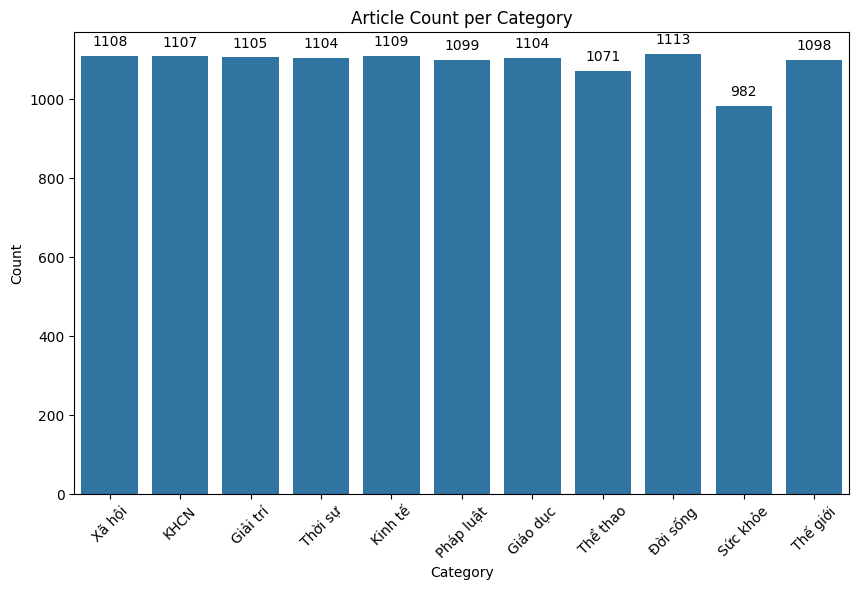

In [7]:
# Tạo một defaultdict để lưu các văn bản theo từng category
category_data = defaultdict(list)
for article in filtered_data:
    category_data[article['metadata']['cat']].append(article)

# Xác định số lượng mẫu tối đa cho mỗi category
number_sample = 12000
max_samples_per_category = number_sample // len(category_data)

# Chọn ngẫu nhiên các mẫu từ mỗi category, giới hạn bởi max_samples_per_category
balanced_data = []
for category, items in category_data.items():
    if len(items) > max_samples_per_category:
        balanced_data.extend(random.sample(items, max_samples_per_category))
    else:
        balanced_data.extend(items)

# Nếu số lượng mẫu không đủ number_sample, bổ sung thêm mẫu ngẫu nhiên từ balanced_data
if len(balanced_data) < number_sample:
    additional_samples = random.sample(balanced_data, number_sample - len(balanced_data))
    balanced_data.extend(additional_samples)

filtered_data_to_use = balanced_data[:number_sample if number_sample < len(balanced_data) else len(balanced_data)]
print(f"Filtered articles to use count: {len(filtered_data_to_use)}")

# Đếm số lượng từng danh mục
category_counts = defaultdict(int)
for item in filtered_data_to_use:
    category_counts[item['metadata']['cat']] += 1

# Vẽ biểu đồ cột
plt.figure(figsize=(10, 6))  # Điều chỉnh kích thước biểu đồ nhỏ hơn
ax = sns.barplot(x=list(category_counts.keys()), y=list(category_counts.values()))
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Article Count per Category')
plt.xticks(rotation=45)

# Thêm số lượng ở trên mỗi cột
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.savefig('balanced-category-distribution.png')
plt.show()

### Làm sạch hơn dữ liệu

In [8]:
# Danh sách stop words tiếng Việt
stop_words = set([
    "bị", "bởi", "cả", "các", "cái", "cần", "càng", "chỉ", "chiếc", "cho", "chứ", "chưa", "chuyện",
    "có", "có_thể", "cứ", "của", "cùng", "cũng", "đã", "đang", "đây", "để", "đến_nỗi", "đều", "điều",
    "do", "đó", "được", "dưới", "gì", "khi", "không", "là", "lại", "lên", "lúc", "mà", "mỗi", "này",
    "nên", "nếu", "ngay", "nhiều", "như", "nhưng", "những", "nơi", "nữa", "phải", "qua", "ra", "rằng",
    "rằng", "rất", "rồi", "sau", "sẽ", "so", "sự", "tại", "theo", "thì", "trên", "trước", "từ", "từng",
    "và", "vẫn", "vào", "vậy", "vì", "việc", "với", "vừa"
])

# Trích xuất dữ liệu từ các bài báo đã được lọc
texts = []
labels = []

# Lặp qua từng bài báo trong dữ liệu đã lọc
for article in filtered_data_to_use:
    # Kết hợp tiêu đề và nội dung bài báo
    text = article.get('title', '') + ' ' + article.get('description', '') + ' ' + article.get('content', '')
    # Lấy nhãn (category) của bài báo
    label = article['metadata']['cat']
    # Thêm văn bản và nhãn vào danh sách tương ứng
    texts.append(text)
    labels.append(label)

# Hàm tiền xử lý văn bản
def preprocess_text(text):
    # Chuyển văn bản thành chữ thường
    text = text.lower()
    # Loại bỏ dấu câu
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    # Loại bỏ khoảng trắng thừa
    text = re.sub(r'\s+', ' ', text).strip()
    # Tách văn bản thành các từ (tokens)
    tokens = text.split()
    # Đếm tổng số từ ban đầu
    total_tokens = len(tokens)
    # Loại bỏ các từ thuộc danh sách stop words
    tokens = [token for token in tokens if token not in stop_words]
    # Tính phần trăm các từ stop words đã bị loại bỏ
    removed_stop_words_percent = (total_tokens - len(tokens)) / total_tokens * 100
    # Trả về văn bản đã được xử lý và phần trăm từ stop words đã bị loại bỏ
    return ' '.join(tokens), removed_stop_words_percent

# Danh sách chứa các văn bản đã qua tiền xử lý
processed_texts = []
# Danh sách chứa phần trăm các từ stop words đã bị loại bỏ trong từng văn bản
sum_stop_words_percents = 0

# Sử dụng tqdm để hiển thị thanh tiến trình khi xử lý các văn bản
tqdm_iter = tqdm(texts, desc="Processing texts")

# Lặp qua từng văn bản trong danh sách văn bản gốc
for i, text in enumerate(tqdm_iter):
    # Tiền xử lý văn bản và tính phần trăm từ stop words đã bị loại bỏ
    processed_text, stop_words_percent = preprocess_text(text)
    # Thêm văn bản đã qua tiền xử lý vào danh sách
    processed_texts.append(processed_text)
    # Thêm phần trăm từ stop words đã bị loại bỏ vào danh sách
    sum_stop_words_percents += stop_words_percent
    # Tính phần trăm trung bình của các từ stop words đã bị loại bỏ
    avg_stop_words_percent = sum_stop_words_percents / (i+1)
    # Cập nhật thanh tiến trình với phần trăm trung bình hiện tại
    tqdm_iter.set_postfix({"avg_stop_words_percent": f"{avg_stop_words_percent:.2f}%"})

# Cập nhật danh sách văn bản gốc với các văn bản đã qua tiền xử lý
texts = processed_texts
# Tính phần trăm trung bình cuối cùng của các từ stop words đã bị loại bỏ
average_stop_words_percent = sum_stop_words_percents / len(texts)

# In ra phần trăm trung bình của các từ stop words đã bị loại bỏ
print(f"Average percentage of stop words removed: {average_stop_words_percent:.2f}%")


Processing texts:   0%|          | 0/12000 [00:00<?, ?it/s]

Average percentage of stop words removed: 18.35%


In [9]:
print("Văn bản sau sử lý: ", texts[0])
print("Nhãn của văn bản: ", labels[0])

Văn bản sau sử lý:  nsnd minh hòa nghỉ hưu miệt mài đi dạy truyền năng lượng tích cực ở tuổi 60 5 năm nghỉ hưu nsnd minh hòa miệt mài đi giảng dạy tham gia bộ phim truyền đi năng lượng tích cực ở tuổi 60 nsnd minh hòa sinh năm 1964 trong gia đình truyền thống nghệ thuật ở hà nội chị học trường sân khấu điện ảnh khóa 19811986 thời gian dài công tác nhà hát kịch hà nội nghỉ hưu năm 2019 nữ nghệ sĩ năm giữ vị trí phó giám đốc nhà hát nsnd minh hòa năm 18 tuổi sở hữu vẻ đẹp đài sắc sảo nsnd minh hòa ghi dấu ấn ở tuyến nhân vật chính diện phản diện dù dạng vai nào bi hài ác thậm chí vai thật hiền lành mình yêu nhân vật say mê sống hết mình nhân vật mới hình hài nhân vật mình muốn đóng chị chia sẻ trong chương trình đẹp việt nữ nghệ sĩ nói chị đóng vai ác ham học hỏi đọc quan sát cuộc sống lẽ nsnd minh hòa ấn tượng đặc biệt vai trùm ma túy bạch yến đa mưu ghê gớm trong phim truyền hình cuồng phong gây sốt màn ảnh chị nghĩ đóng vai ác thế đường chắc mọi người ghét ném đá lắm cuối hóa thân xuấ

## Huấn luyện và đánh giá các mô hình truyền thống

### Tạo dữ liệu huấn luyện và kiểm thử cho các mô hình truyền thống

In [10]:
# Khai báo mảng label y
y = np.array(labels)

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
texts_train, texts_test, y_train, y_test = train_test_split(texts, y, test_size=0.2, stratify=y, random_state=42)

# Encode labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

print("Nhãn gốc: ", y_train[:5])
print("Nhãn sau khi mã hóa: ", y_train_enc[:5])

# Shuffle the training data
texts_train, y_train_enc = shuffle(texts_train, y_train_enc, random_state=42)

# Vectorize texts using TF-IDF for SVM
tfidf_vectorizer = TfidfVectorizer(max_features=5000, tokenizer=lambda x: x, preprocessor=lambda x: x, token_pattern=None)
X_train_tfidf = tfidf_vectorizer.fit_transform(texts_train)
X_test_tfidf = tfidf_vectorizer.transform(texts_test)

print("Kích thức của tập train: ", X_train_tfidf.shape)

Nhãn gốc:  ['Đời sống' 'Thời sự' 'Thế giới' 'Đời sống' 'Kinh tế']
Nhãn sau khi mã hóa:  [10  8  6 10  3]


Kích thức của tập train:  (9600, 182)


### Khởi tạo, huấn luyện và đánh giá các mô hình truyền thống

Mô hình Naive Bayes

In [11]:
# Naive Bayes model
nb_model = MultinomialNB(alpha=1.0)

# Fit dữ liệu
nb_model.fit(X_train_tfidf, y_train_enc)

# Dự đoán
y_pred_enc_nb = nb_model.predict(X_test_tfidf)
y_pred_nb = le.inverse_transform(y_pred_enc_nb)

# Báo cáo phân loại cho Naive Bayes
report_nb = classification_report(y_test, y_pred_nb, output_dict=True, zero_division=0)

Mô hình Logistic Regression

In [12]:
### YOUR START CODE HERE ###
# Logistic Regression model
lr_model = LogisticRegression(max_iter=1000)

# Fit dữ liệu
lr_model.fit(X_train_tfidf, y_train_enc)

# Dự đoán
y_pred_enc_lr = lr_model.predict(X_test_tfidf)
y_pred_lr = le.inverse_transform(y_pred_enc_lr)

# Báo cáo phân loại cho Logistic Regression
report_lr = classification_report(y_test, y_pred_lr, output_dict=True, zero_division=0)
### YOUR END CODE HERE ###

Mô hình Random Forest

In [13]:
### YOUR START CODE HERE ###
# Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit dữ liệu
rf_model.fit(X_train_tfidf, y_train_enc)
# Dự đoán
y_pred_enc_rf = rf_model.predict(X_test_tfidf)
y_pred_rf = le.inverse_transform(y_pred_enc_rf)

# Báo cáo phân loại cho Logistic Regression
report_rf = classification_report(y_test, y_pred_rf, output_dict=True, zero_division=0)
### YOUR END CODE HERE ###

Mô hình SVM

In [14]:
### YOUR START CODE HERE ###
# SVM model
svc_model = SVC(kernel='linear')

# Fit dữ liệu
svc_model.fit(X_train_tfidf, y_train_enc)
# Dự đoán
y_pred_enc_svc = svc_model.predict(X_test_tfidf)
y_pred_svc = le.inverse_transform(y_pred_enc_svc)

# Báo cáo phân loại cho Logistic Regression
report_svc = classification_report(y_test, y_pred_svc, output_dict=True, zero_division=0)
### YOUR END CODE HERE ###

### Vẽ biểu đồ


Naive Bayes Metrics:
Giáo dục: Precision=0.83, Recall=0.65, F1-Score=0.73
Giải trí: Precision=0.47, Recall=0.32, F1-Score=0.38
KHCN: Precision=0.39, Recall=0.53, F1-Score=0.45
Kinh tế: Precision=0.46, Recall=0.47, F1-Score=0.47
Pháp luật: Precision=0.65, Recall=0.74, F1-Score=0.69
Sức khỏe: Precision=1.00, Recall=0.01, F1-Score=0.01
Thế giới: Precision=0.76, Recall=0.74, F1-Score=0.75
Thể thao: Precision=0.84, Recall=0.76, F1-Score=0.80
Thời sự: Precision=0.53, Recall=0.38, F1-Score=0.44
Xã hội: Precision=0.39, Recall=0.47, F1-Score=0.43
Đời sống: Precision=0.31, Recall=0.66, F1-Score=0.42
Overall Accuracy: 0.52

Logistic Regression Metrics:
Giáo dục: Precision=0.69, Recall=0.82, F1-Score=0.75
Giải trí: Precision=0.53, Recall=0.40, F1-Score=0.46
KHCN: Precision=0.46, Recall=0.49, F1-Score=0.47
Kinh tế: Precision=0.59, Recall=0.44, F1-Score=0.51
Pháp luật: Precision=0.60, Recall=0.71, F1-Score=0.65
Sức khỏe: Precision=0.73, Recall=0.64, F1-Score=0.68
Thế giới: Precision=0.72, Recall=0.


Random Forest Metrics:
Giáo dục: Precision=0.86, Recall=0.89, F1-Score=0.87
Giải trí: Precision=0.52, Recall=0.55, F1-Score=0.53
KHCN: Precision=0.60, Recall=0.62, F1-Score=0.61
Kinh tế: Precision=0.69, Recall=0.54, F1-Score=0.60
Pháp luật: Precision=0.67, Recall=0.80, F1-Score=0.73
Sức khỏe: Precision=0.80, Recall=0.79, F1-Score=0.79
Thế giới: Precision=0.76, Recall=0.79, F1-Score=0.77
Thể thao: Precision=0.85, Recall=0.96, F1-Score=0.90
Thời sự: Precision=0.61, Recall=0.61, F1-Score=0.61
Xã hội: Precision=0.66, Recall=0.54, F1-Score=0.59
Đời sống: Precision=0.60, Recall=0.56, F1-Score=0.58
Overall Accuracy: 0.69

SVC Metrics:
Giáo dục: Precision=0.88, Recall=0.77, F1-Score=0.82
Giải trí: Precision=0.47, Recall=0.55, F1-Score=0.51
KHCN: Precision=0.44, Recall=0.59, F1-Score=0.50
Kinh tế: Precision=0.66, Recall=0.43, F1-Score=0.52
Pháp luật: Precision=0.61, Recall=0.70, F1-Score=0.65
Sức khỏe: Precision=0.77, Recall=0.62, F1-Score=0.69
Thế giới: Precision=0.76, Recall=0.74, F1-Score=0

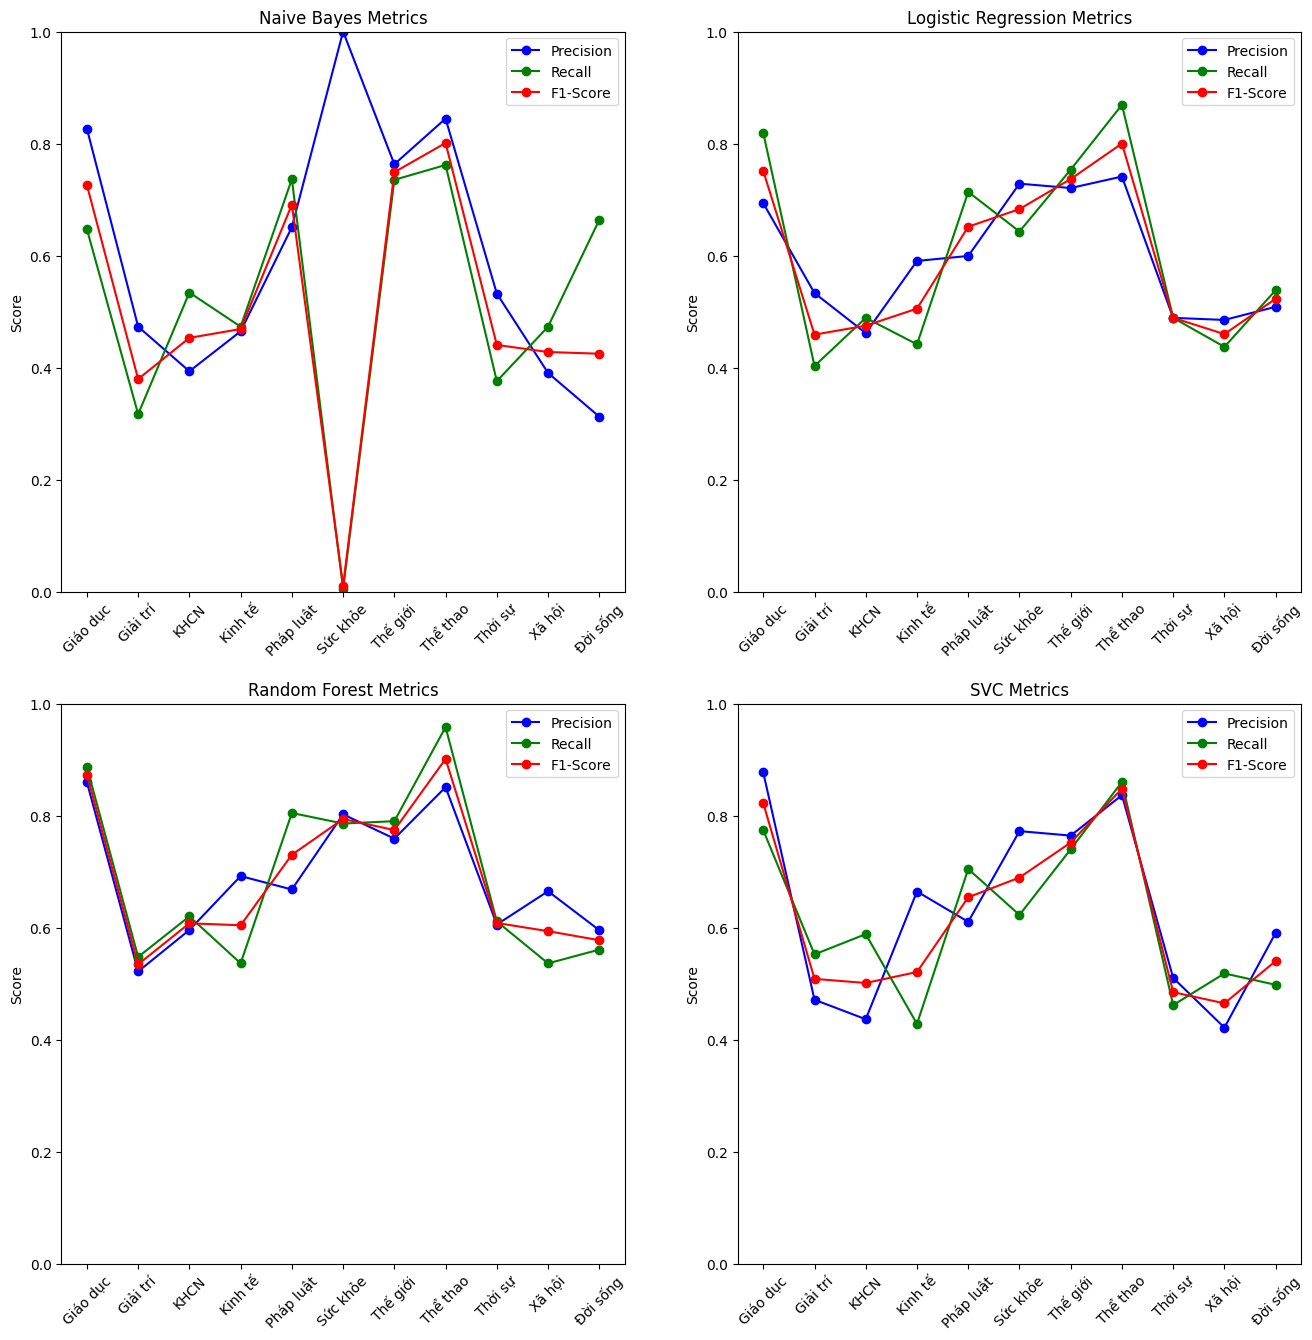

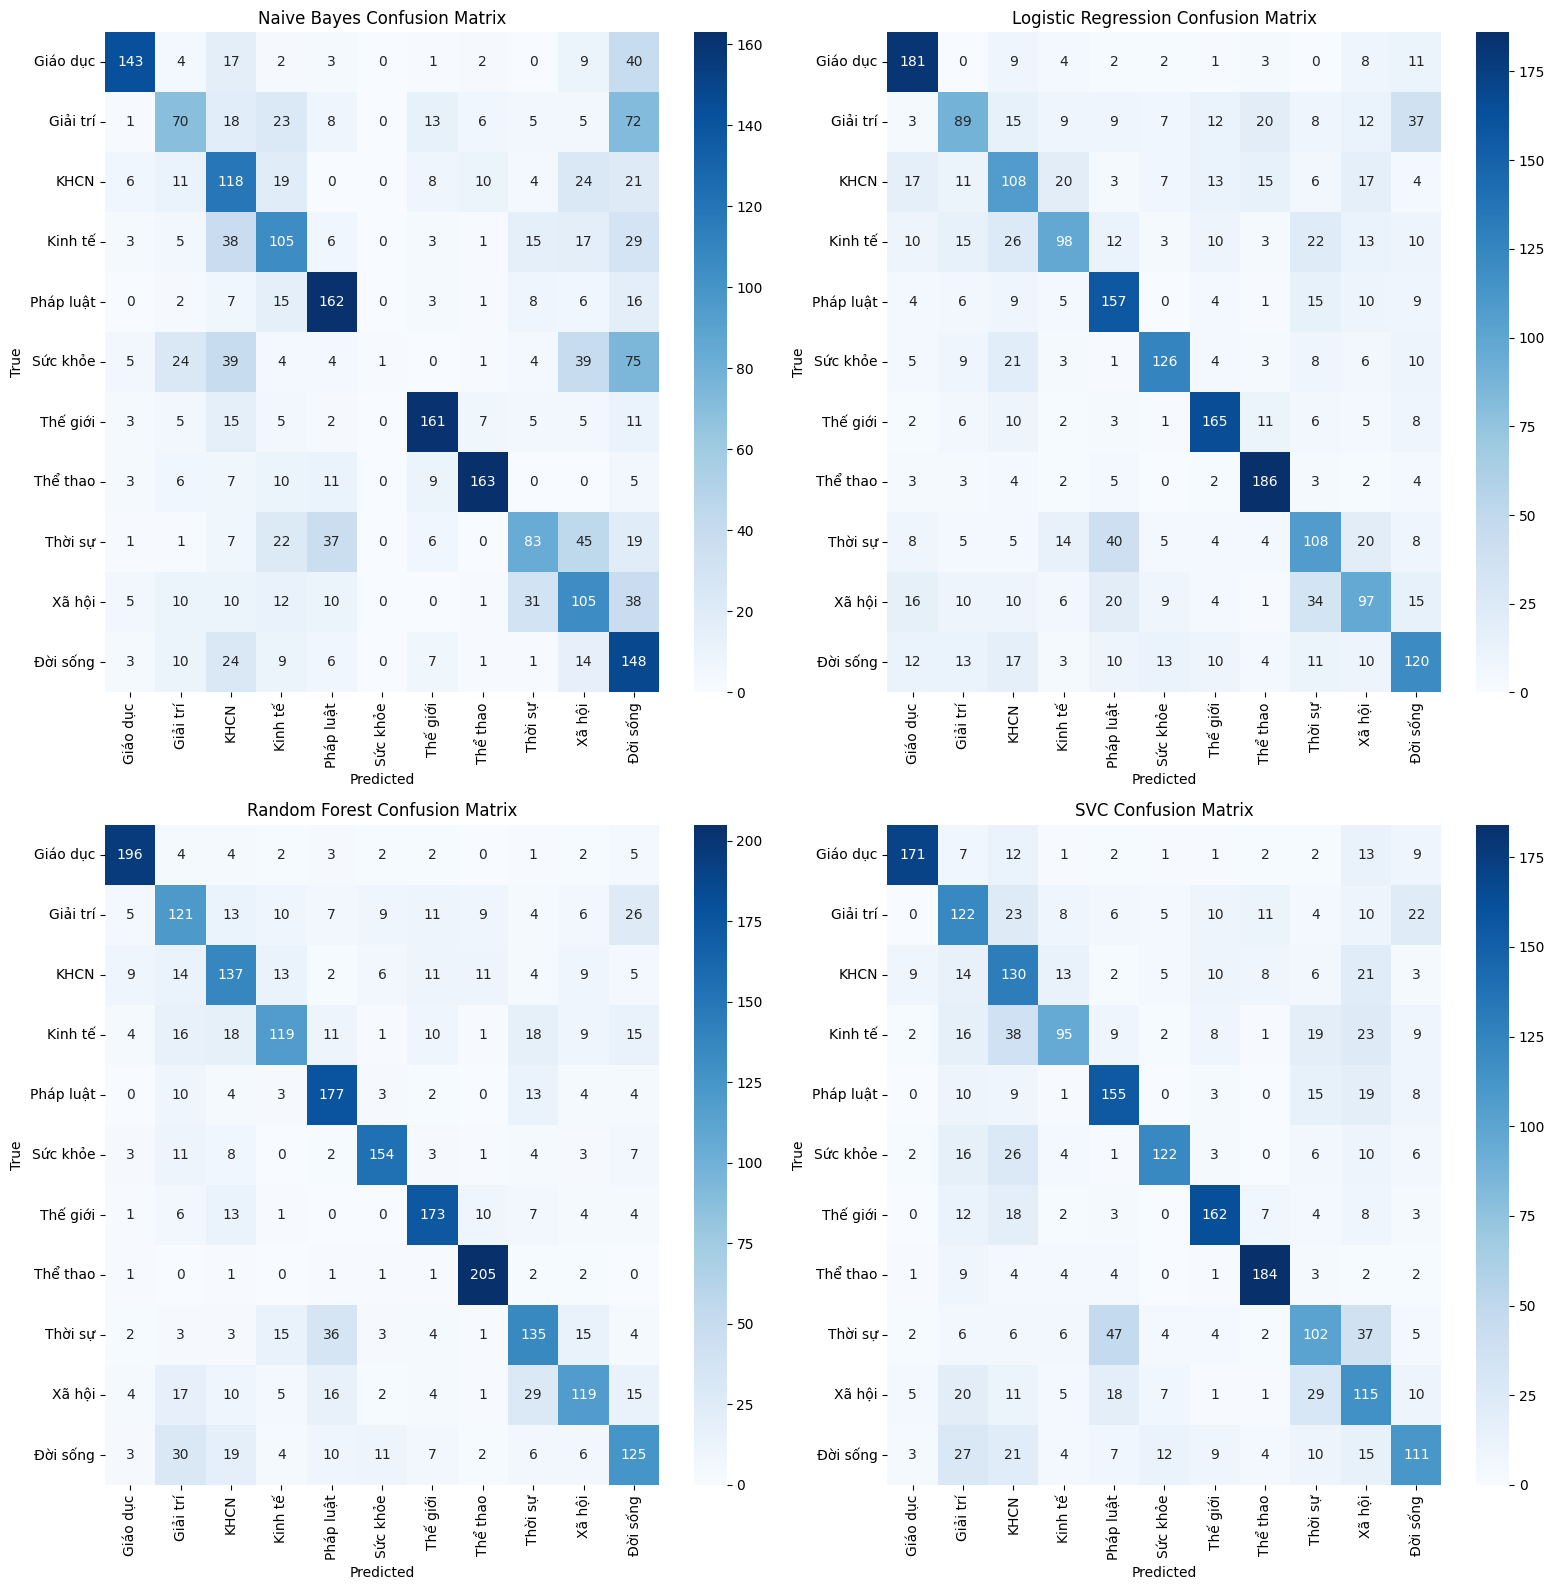

In [15]:
# Tạo danh sách các báo cáo phân loại
reports = {
    'Naive Bayes': report_nb,
    'Logistic Regression': report_lr,
    'Random Forest': report_rf,
    'SVC': report_svc
}

fig, axs = plt.subplots(2, 2, figsize=(16, 16))
fig_cm, axs_cm = plt.subplots(2, 2, figsize=(16, 16))

for i, (name, report) in enumerate(reports.items()):
    categories = list(report.keys())[:-3]  # exclude 'accuracy', 'macro avg', 'weighted avg'
    precisions = [report[cat]['precision'] for cat in categories]
    recalls = [report[cat]['recall'] for cat in categories]
    f1_scores = [report[cat]['f1-score'] for cat in categories]

    # In ra các thông số
    print(f'\n{name} Metrics:')
    for category in categories:
        print(f"{category}: Precision={report[category]['precision']:.2f}, Recall={report[category]['recall']:.2f}, F1-Score={report[category]['f1-score']:.2f}")

    # In ra độ chính xác trung bình
    accuracy = report['accuracy']
    print(f'Overall Accuracy: {accuracy:.2f}')

    # Vẽ biểu đồ đường
    axs[i // 2, i % 2].plot(categories, precisions, marker='o', label='Precision', color='blue')
    axs[i // 2, i % 2].plot(categories, recalls, marker='o', label='Recall', color='green')
    axs[i // 2, i % 2].plot(categories, f1_scores, marker='o', label='F1-Score', color='red')
    axs[i // 2, i % 2].set_ylim(0, 1)  # Đặt giới hạn trục y từ 0 đến 1
    axs[i // 2, i % 2].set_title(f'{name} Metrics')
    axs[i // 2, i % 2].set_ylabel('Score')
    axs[i // 2, i % 2].legend()
    axs[i // 2, i % 2].tick_params(axis='x', rotation=45)

    # Vẽ ma trận nhầm lẫn
    if name == 'Naive Bayes':
        cm = confusion_matrix(y_test, y_pred_nb, labels=le.classes_)
    elif name == 'Logistic Regression':
        cm = confusion_matrix(y_test, y_pred_lr, labels=le.classes_)
    elif name == 'Random Forest':
        cm = confusion_matrix(y_test, y_pred_rf, labels=le.classes_)
    elif name == 'SVC':
        cm = confusion_matrix(y_test, y_pred_svc, labels=le.classes_)

    sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues', ax=axs_cm[i // 2, i % 2])
    axs_cm[i // 2, i % 2].set_title(f'{name} Confusion Matrix')
    axs_cm[i // 2, i % 2].set_xlabel('Predicted')
    axs_cm[i // 2, i % 2].set_ylabel('True')

plt.tight_layout()
plt.savefig('traditional-ml-models.png')
plt.show()

In [16]:
# In ra nhãn dự đoán và nhãn thực tế
print("Nội dung bài báo: ", texts_train[0])
print("Nhãn dự đoán:" , le.inverse_transform(rf_model.predict(X_test_tfidf[:1])))
print("Nhãn thực tế: ", le.inverse_transform(y_train_enc[:1]))

Nội dung bài báo:  cơn đau ám ảnh nhổ răng khôn sót chân răng răng khôn mọc khó quá trình nhổ diễn dài đau đớn khiến anh đsđ 25 tuổi hà nội bỏ dở chân răng lấy anh chịu đựng cơn đau hành hạ một đêm tới hệ thống y tế thu cúc tci xử lý nỗi ám ảnh nhổ răng khôn anh đsđ 2 lần nhổ răng khôn mới thành công ảnh thu cúc tci anh đ một răng khôn khá lâu răng mọc ngầm lệch ở phía hàm dẫn tới tình trạng đau nhức ảnh hưởng tới sinh hoạt hàng ngày anh quyết định đi nhổ bỏ răng một nha khoa gần nhà phương pháp anh lựa chọn nhổ răng khôn bằng kìm chi phí thấp hơn tuy nhiên quá trình nhổ răng diễn mấy suôn sẻ vị trí răng mọc khá sâu lệch nha sĩ mở xương chia cắt thân răng thành mảnh đưa ngoài quá trình nhổ diễn quá lâu đau đớn dù anh đ tiêm thuốc tê sợ hãi anh đ thể chịu nổi bỏ về trong còn 1 phần răng nằm phía sâu bên lấy ca nhổ răng tôi thể ăn mất ngủ đêm đau đớn ê nhức dồn dập sáng hôm tôi quyết định tới khoa răng hàm mặt hệ thống y tế thu cúc tci tư vấn anh nói dọn sạch chân răng khôn công nghệ pie

## Huấn luyện và đánh giá các mô hình học sâu

### Tạo dữ liệu huấn luyện và kiểm thử cho các mô hình học sâu

Tải mô hình phobert dùng để chuyển word thành vector

In [17]:
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel

# Tải PhoBERT Tokenizer và Model
tokenizer = AutoTokenizer.from_pretrained('vinai/phobert-base')
embeder = AutoModel.from_pretrained('vinai/phobert-base')

# Chuyển mô hình sang GPU nếu có
embeder.to(device)

/home/ltpq/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(64001, 768, padding_idx=1)
    (position_embeddings): Embedding(258, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dropou

Hàm chuyển dãy word thành dãy vector

In [18]:
# Chuyển đổi từ thành vector.
def encode_texts(texts, tokenizer, embeder, max_length=256):
    encoded_texts = []  # Danh sách để lưu văn bản sau khi mã hóa.

    for text in tqdm(texts, desc="Chuyển từ thành vector"):
        # Chuyển văn bản thành các tensor đầu vào cho mô hình, cắt hoặc padding đến độ dài tối đa.
        inputs = tokenizer(text, return_tensors="pt", max_length=max_length, truncation=True, padding="max_length").to(device)

        # Không tính gradient vì chỉ thực hiện suy luận (inference), không huấn luyện.
        with torch.no_grad():
            outputs = embeder(**inputs)  # Truyền các tensor đầu vào qua mô hình để lấy các vector mã hóa.

        # Lấy vector mã hóa từ `last_hidden_state` và loại bỏ chiều batch.
        encoded_texts.append(outputs.last_hidden_state.squeeze(0))

    # Chuyển danh sách các tensor thành một tensor duy nhất.
    return torch.stack(encoded_texts)

In [19]:
test = ["Xin chào", "Đây là chương trình AI4E"]
encode_texts(test, tokenizer, embeder).shape

Chuyển từ thành vector:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([2, 256, 768])

Chuyển đổi dữ liệu

In [20]:
# Vectorize texts using phobert
X_train_phobert = encode_texts(texts_train, tokenizer, embeder)
X_test_phobert = encode_texts(texts_test, tokenizer, embeder)

Chuyển từ thành vector:   0%|          | 0/9600 [00:00<?, ?it/s]

Chuyển từ thành vector:   0%|          | 0/2400 [00:00<?, ?it/s]

Tạo Dataloader

In [21]:
# Khai báo lớp dùng để tạo dataset
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

# Tạo Dataset cho tập huấn luyện và tập kiểm thử
train_dataset = TextDataset(X_train_phobert, y_train_enc)
test_dataset = TextDataset(X_test_phobert, y_test_enc)

# Tạo DataLoader cho tập huấn luyện và tập kiểm thử
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### Định nghĩa các lớp mô hình học sâu

In [22]:
# Xây dựng mô hình RNN
class RNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(RNNClassifier, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.num_layers = num_layers

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

# Xây dựng mô hình LSTM
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.num_layers = num_layers

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Xây dựng mô hình CNN
class CNNClassifier(nn.Module):
    def __init__(self, input_size, output_size, num_filters, kernel_size, max_length=256):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=num_filters, kernel_size=kernel_size)
        self.pool = nn.MaxPool1d(kernel_size=max_length - kernel_size + 1)
        self.fc = nn.Linear(num_filters, output_size)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Đổi thứ tự để phù hợp với Conv1d (batch_size, input_size, max_length)
        x = self.conv1(x)
        x = self.pool(x).squeeze(2)
        x = self.fc(x)
        return x

class CNNClassifier(nn.Module):
    def __init__(self, input_size, output_size, num_filters, kernel_size, max_length=256):
        super(CNNClassifier, self).__init__()

        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=num_filters, kernel_size=kernel_size)
        self.bn1 = nn.BatchNorm1d(num_filters)
        self.conv2 = nn.Conv1d(in_channels=num_filters, out_channels=num_filters*2, kernel_size=kernel_size)
        # self.bn2 = nn.BatchNorm1d(num_filters*2)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.drop = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(num_filters*2 * ((max_length - 2*(kernel_size-1)) // 2), 256)
        self.fc2 = nn.Linear(256, output_size)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Adjust input dimensions for Conv1d
        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = self.drop(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


### Khai báo các mô hình học sâu

In [23]:
# Thiết lập các thông số
input_size = 768  # Kích thước của vector ẩn PhoBERT
output_size = len(le.classes_) # Số lượng lớp

### YOUR START CODE HERE ###
hidden_size = 512
num_filters = 10
kernel_size = 5
### YOUR END CODE HERE ###

In [24]:
# Khởi tạo các mô hình
deep_models = {
    'CNN': CNNClassifier(input_size, output_size, num_filters, kernel_size, max_length=256).to(device),
    'RNN': RNNClassifier(input_size, hidden_size, output_size, num_layers=3).to(device),
    'LSTM': LSTMClassifier(input_size, hidden_size, output_size, num_layers=1).to(device),
}

### Huấn luyện và đánh giá các mô hình học sâu

In [25]:
# Hàm huấn luyện và đánh giá mô hình
def train_and_evaluate(model, train_loader, test_loader, num_epochs=10, criterion=None, optimizer_fn=None, scheduler_fn=None):
    # Khởi tạo optimizer
    optimizer = optimizer_fn(model.parameters())

    # Khởi tạo scheduler
    scheduler = scheduler_fn(optimizer)

    for epoch in range(num_epochs):
        model.train()
        for texts, labels in train_loader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if scheduler is not None:
            scheduler.step()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for texts, labels in test_loader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_labels, all_preds

Lựa chọn criterion, optimizer, và scheduler

In [26]:
### YOUR START CODE HERE ###
# Khai báo criterion
criterion = nn.CrossEntropyLoss()

# Hàm tạo optimizer
def optimizer_fn(params):
   return torch.optim.Adam(params, lr=0.001)

# Hàm tạo scheduler
def scheduler_fn(optimizer):
    return torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

num_epochs = 20
### YOUR START CODE HERE ###

### Vẽ biểu đồ

Training CNN model...


Epoch [1/20], Loss: 1.1235


Epoch [2/20], Loss: 0.6724


Epoch [3/20], Loss: 0.6471


Epoch [4/20], Loss: 0.5227


Epoch [5/20], Loss: 0.7188


Epoch [6/20], Loss: 0.2918


Epoch [7/20], Loss: 0.2725


Epoch [8/20], Loss: 0.3009


Epoch [9/20], Loss: 0.1483


Epoch [10/20], Loss: 0.1807


Epoch [11/20], Loss: 0.2961


Epoch [12/20], Loss: 0.2108


Epoch [13/20], Loss: 0.3689


Epoch [14/20], Loss: 0.1731


Epoch [15/20], Loss: 0.2741


Epoch [16/20], Loss: 0.4090


Epoch [17/20], Loss: 0.1962


Epoch [18/20], Loss: 0.2066


Epoch [19/20], Loss: 0.2652


Epoch [20/20], Loss: 0.0969



CNN Metrics:
Giáo dục: Precision=0.91, Recall=0.93, F1-Score=0.92
Giải trí: Precision=0.78, Recall=0.79, F1-Score=0.78
KHCN: Precision=0.81, Recall=0.77, F1-Score=0.79
Kinh tế: Precision=0.82, Recall=0.74, F1-Score=0.78
Pháp luật: Precision=0.86, Recall=0.91, F1-Score=0.89
Sức khỏe: Precision=0.88, Recall=0.89, F1-Score=0.89
Thế giới: Precision=0.88, Recall=0.89, F1-Score=0.88
Thể thao: Precision=0.94, Recall=0.98, F1-Score=0.96
Thời sự: Precision=0.69, Recall=0.72, F1-Score=0.71
Xã hội: Precision=0.70, Recall=0.61, F1-Score=0.65
Đời sống: Precision=0.67, Recall=0.72, F1-Score=0.69
Overall Accuracy: 0.81

Training RNN model...


Epoch [1/20], Loss: 0.9787


Epoch [2/20], Loss: 1.0192


Epoch [3/20], Loss: 0.7727


Epoch [4/20], Loss: 0.6359


Epoch [5/20], Loss: 0.5264


Epoch [6/20], Loss: 0.4237


Epoch [7/20], Loss: 0.2944


Epoch [8/20], Loss: 0.2526


Epoch [9/20], Loss: 0.2807


Epoch [10/20], Loss: 0.1719


Epoch [11/20], Loss: 0.2332


Epoch [12/20], Loss: 0.0821


Epoch [13/20], Loss: 0.1018


Epoch [14/20], Loss: 0.0558


Epoch [15/20], Loss: 0.0828


Epoch [16/20], Loss: 0.1142


Epoch [17/20], Loss: 0.1108


Epoch [18/20], Loss: 0.0934


Epoch [19/20], Loss: 0.1191


Epoch [20/20], Loss: 0.0639



RNN Metrics:
Giáo dục: Precision=0.89, Recall=0.89, F1-Score=0.89
Giải trí: Precision=0.69, Recall=0.67, F1-Score=0.68
KHCN: Precision=0.73, Recall=0.72, F1-Score=0.73
Kinh tế: Precision=0.72, Recall=0.67, F1-Score=0.70
Pháp luật: Precision=0.81, Recall=0.84, F1-Score=0.83
Sức khỏe: Precision=0.88, Recall=0.89, F1-Score=0.88
Thế giới: Precision=0.86, Recall=0.84, F1-Score=0.85
Thể thao: Precision=0.93, Recall=0.96, F1-Score=0.94
Thời sự: Precision=0.65, Recall=0.70, F1-Score=0.67
Xã hội: Precision=0.57, Recall=0.52, F1-Score=0.55
Đời sống: Precision=0.56, Recall=0.62, F1-Score=0.59
Overall Accuracy: 0.75

Training LSTM model...


Epoch [1/20], Loss: 0.5949


Epoch [2/20], Loss: 0.5417


Epoch [3/20], Loss: 0.5531


Epoch [4/20], Loss: 0.6408


Epoch [5/20], Loss: 0.2968


Epoch [6/20], Loss: 0.2143


Epoch [7/20], Loss: 0.1232


Epoch [8/20], Loss: 0.1761


Epoch [9/20], Loss: 0.0651


Epoch [10/20], Loss: 0.0727


Epoch [11/20], Loss: 0.0429


Epoch [12/20], Loss: 0.0533


Epoch [13/20], Loss: 0.0646


Epoch [14/20], Loss: 0.0857


Epoch [15/20], Loss: 0.0459


Epoch [16/20], Loss: 0.0253


Epoch [17/20], Loss: 0.0903


Epoch [18/20], Loss: 0.0801


Epoch [19/20], Loss: 0.0277


Epoch [20/20], Loss: 0.0296



LSTM Metrics:
Giáo dục: Precision=0.88, Recall=0.88, F1-Score=0.88
Giải trí: Precision=0.71, Recall=0.73, F1-Score=0.72
KHCN: Precision=0.73, Recall=0.66, F1-Score=0.70
Kinh tế: Precision=0.68, Recall=0.69, F1-Score=0.69
Pháp luật: Precision=0.84, Recall=0.83, F1-Score=0.83
Sức khỏe: Precision=0.86, Recall=0.87, F1-Score=0.87
Thế giới: Precision=0.85, Recall=0.86, F1-Score=0.86
Thể thao: Precision=0.92, Recall=0.98, F1-Score=0.95
Thời sự: Precision=0.66, Recall=0.67, F1-Score=0.66
Xã hội: Precision=0.62, Recall=0.59, F1-Score=0.60
Đời sống: Precision=0.62, Recall=0.64, F1-Score=0.63
Overall Accuracy: 0.76



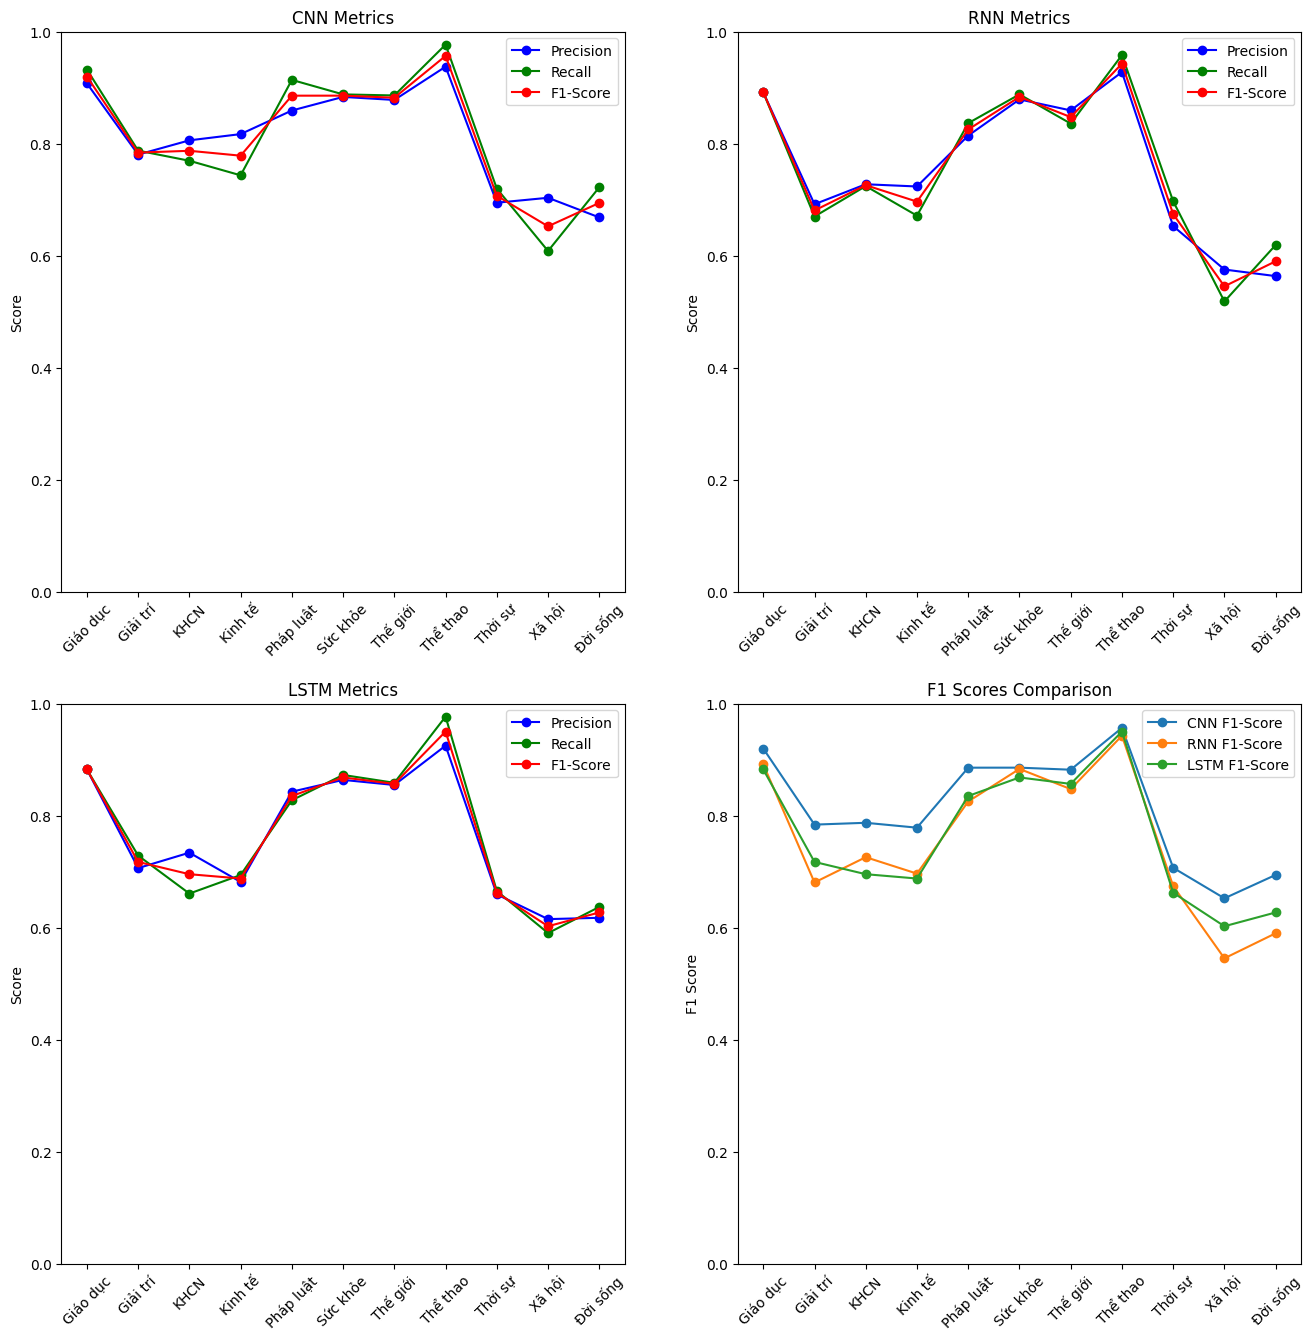

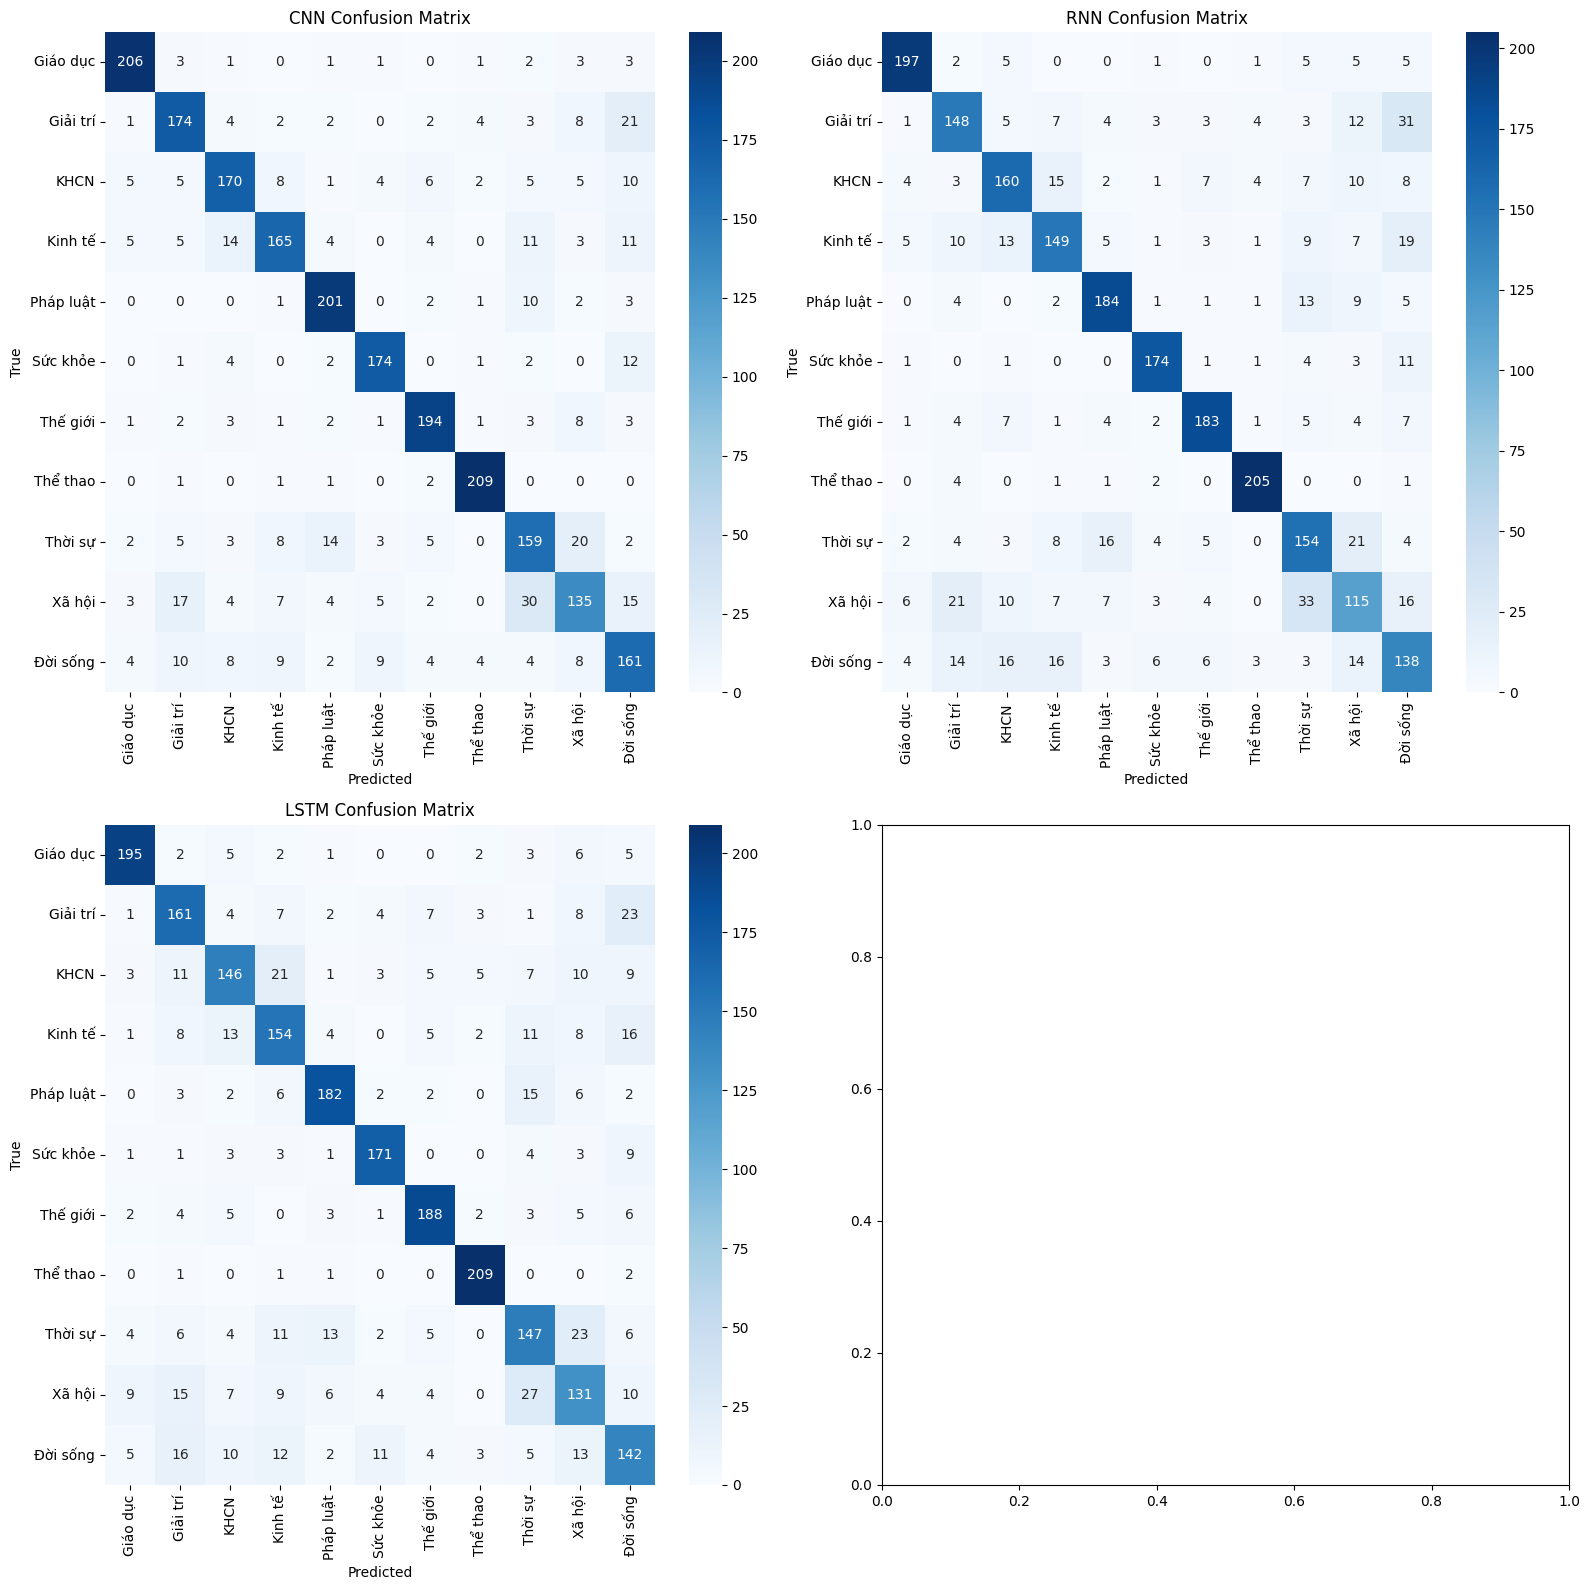

In [27]:
# Hình vẽ kết quả của mô hình sau khi train
fig, axs = plt.subplots(2, 2, figsize=(16, 16))
fig_cm, axs_cm = plt.subplots(2, 2, figsize=(16, 16))

# Lưu trữ F1 scores của các mô hình
model_f1_scores = {}

for i, (name, model) in enumerate(deep_models.items()):
    print(f"Training {name} model...")
    y_test, y_pred = train_and_evaluate(model, train_loader, test_loader, num_epochs,
                                        criterion=criterion, optimizer_fn=optimizer_fn, scheduler_fn=scheduler_fn)
    y_test = le.inverse_transform(y_test)
    y_pred = le.inverse_transform(y_pred)

    # Tạo báo cáo phân loại
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    categories = list(report.keys())[:-3]  # exclude 'accuracy', 'macro avg', 'weighted avg'

    # Tạo dữ liệu để vẽ biểu đồ
    precisions = [report[cat]['precision'] for cat in categories]
    recalls = [report[cat]['recall'] for cat in categories]
    f1_scores = [report[cat]['f1-score'] for cat in categories]
    model_f1_scores[name] = f1_scores

    # In ra các thông số
    print(f'\n{name} Metrics:')
    for category in categories:
        print(f"{category}: Precision={report[category]['precision']:.2f}, Recall={report[category]['recall']:.2f}, F1-Score={report[category]['f1-score']:.2f}")

    # In ra độ chính xác trung bình
    accuracy = report['accuracy']
    print(f'Overall Accuracy: {accuracy:.2f}\n')

    # Vẽ biểu đồ đường
    axs[i // 2, i % 2].plot(categories, precisions, marker='o', label='Precision', color='blue')
    axs[i // 2, i % 2].plot(categories, recalls, marker='o', label='Recall', color='green')
    axs[i // 2, i % 2].plot(categories, f1_scores, marker='o', label='F1-Score', color='red')
    axs[i // 2, i % 2].set_ylim(0, 1)  # Đặt giới hạn trục y từ 0 đến 1
    axs[i // 2, i % 2].set_title(f'{name} Metrics')
    axs[i // 2, i % 2].set_ylabel('Score')
    axs[i // 2, i % 2].legend()
    axs[i // 2, i % 2].tick_params(axis='x', rotation=45)

    # Vẽ ma trận nhầm lẫn
    cm = confusion_matrix(y_test, y_pred, labels=le.classes_)
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues', ax=axs_cm[i // 2, i % 2])
    axs_cm[i // 2, i % 2].set_title(f'{name} Confusion Matrix')
    axs_cm[i // 2, i % 2].set_xlabel('Predicted')
    axs_cm[i // 2, i % 2].set_ylabel('True')

# Vẽ F1 scores của cả 3 mô hình lên subplot thứ 4
for name, f1_scores in model_f1_scores.items():
    axs[1, 1].plot(categories, f1_scores, marker='o', label=f'{name} F1-Score')
axs[1, 1].set_ylim(0, 1)
axs[1, 1].set_title('F1 Scores Comparison')
axs[1, 1].set_ylabel('F1 Score')
axs[1, 1].legend()
axs[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('modern-dl-models.png')
plt.show()

In [28]:
# In nhãn dự đoán và nhãn thực tế
print("Văn bản đầu vào: ", texts_test[0])
print("Nhãn dự đoán: ", y_pred[0])
print("Nhãn thực tế: ", y_test[0])

Văn bản đầu vào:  tiết lộ mới về apple watch series 10 apple watch series 10 hai phiên bản kích thước lần lượt 44mm 49mm thay 41mm 45mm dự kiến thiết giới thiệu tháng 9 tới trong một bài đăng gần nhà phân tích mingchi kuo tiết lộ đồng hồ apple watch thế hệ tiếp thiết kế mỏng hơn màn hình kích thước lớn hơn phiên bản tiền nhiệm apple watch series 10 thiết kế mỏng hơn màn hình lớn hơn ảnh cnbc cụ thể apple watch series 10 hai phiên bản kích thước lần lượt 44mm 49mm thay 41mm 45mm dự kiến thiết giới thiệu tháng 9 tới thời điểm dòng iphone 16 trong thông số phần cứng apple watch ultra thế hệ mới giữ nguyên phiên bản tiền nhiệm khả năng apple giới thiệu thêm một phiên bản màu sắc mới dòng sản phẩm kuo biết thêm một số bộ phận đồng hồ thể sản xuất bằng công nghệ in 3d kuo bright laser technologies cung cấp bộ phận in 3d động thái nhằm giảm thời gian sản xuất tối ưu lượng nguyên vật liệu sử dụng kuo nói quá trình thử nghiệm cải thiện đáng kể hiệu quả sản xuất đồng hồ
Nhãn dự đoán:  KHCN
Nhãn 

## Bài tập về nhà
Gán nhãn lại mục metadata.cat trong file text_no_cat.json, tải file đã gán nhãn lên trên github và nộp lại link.

Link file text_no_cat: https://github.com/nmquang003/AI4E/blob/main/test_news_no_cat.json

Link file categories: https://github.com/nmquang003/AI4E/blob/main/categories.txt

### Tải Test dataset

In [29]:
# URL trực tiếp đến file JSON thô trên GitHub
url = 'https://github.com/nmquang003/AI4E/blob/main/test_news_no_cat.json?raw=true'

# Tải nội dung của file
response = requests.get(url)

# Kiểm tra mã trạng thái phản hồi để đảm bảo rằng yêu cầu thành công
if response.status_code == 200:
    try:
        data = response.json()  # Đọc nội dung file JSON
        # Hiển thị phần tử đầu tiên của file JSON
        if isinstance(data, list) and len(data) > 0:
            pprint(json.dumps(data[0], indent=4, ensure_ascii=False))
        else:
            print("Dữ liệu JSON không phải là một danh sách hoặc danh sách trống.")

    except json.JSONDecodeError as e:
        print("JSONDecodeError: Không thể phân tích nội dung JSON.")
        print("Nội dung phản hồi không phải là JSON hợp lệ:")
        print(response.text)  # In ra nội dung phản hồi để kiểm tra
else:
    print(f"Yêu cầu thất bại với mã trạng thái {response.status_code}")
    print("Nội dung phản hồi:", response.text)

('{\n'
 '    "url": null,\n'
 '    "title": "Nhiều tháng đóng bảo hiểm xã hội bỗng \\"biến mất\\" trên ứng '
 'dụng quản lý",\n'
 '    "description": "Một số người lao động truy cập vào tài khoản bảo hiểm xã '
 'hội (BHXH) số - VssID thì thấy quá trình tham gia của mình \\"biến mất\\" '
 'nhiều tháng.",\n'
 '    "content": "Chị Ngọc Phương tham gia BHXh tự nguyện từ tháng 12/2021. '
 'Bắt đầu từ tháng 11/2023 đến nay, chị Phương tham gia BHXH bắt buộc tại công '
 'ty. Tuy nhiên, khi truy cập tài khoản VssID, chị Phương không thấy quá trình '
 'tham gia BHXH của mình được cập nhật.\\nCũng giống Phương, chị Thanh Tuyền '
 'tham gia BHXH từ tháng 7/2017 đến nay, trải qua 3 công ty và có 2 giai đoạn '
 'tạm ngừng tham gia. Tuy nhiên, khi truy cập tài khoản VssID, chị Tuyền phát '
 'hiện quá trình tham gia của mình thiếu mất giai đoạn làm việc ở công ty thứ '
 '2, kéo dài từ tháng 9/2021 đến tháng 3/2022.\\nMới đây, anh Tuấn (làm việc '
 'tại một công ty dịch vụ công ích ở TPHCM) truy cập t

### Tiền xử lý dữ liệu

#### Làm sạch dữ liệu - remove stop words

In [30]:
texts = []
for article in data:
    text = article.get('title', '') + ' ' + article.get('description', '') + ' ' + article.get('content', '')
    texts.append(text)

# Hàm tiền xử lý văn bản
def preprocess_text(text):
    text = text.lower()
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = text.split()
    total_tokens = len(tokens)
    tokens = [token for token in tokens if token not in stop_words]
    removed_stop_words_percent = (total_tokens - len(tokens)) / total_tokens * 100
    return ' '.join(tokens), removed_stop_words_percent

processed_texts = []
sum_stop_words_percents = 0

# Sử dụng tqdm để hiển thị thanh tiến trình khi xử lý các văn bản
tqdm_iter = tqdm(texts, desc="Processing texts")

for i, text in enumerate(tqdm_iter):
    processed_text, stop_words_percent = preprocess_text(text)
    processed_texts.append(processed_text)
    sum_stop_words_percents += stop_words_percent
    avg_stop_words_percent = sum_stop_words_percents / (i+1)
    tqdm_iter.set_postfix({"avg_stop_words_percent": f"{avg_stop_words_percent:.2f}%"})

# Cập nhật danh sách văn bản gốc với các văn bản đã qua tiền xử lý
texts = processed_texts
average_stop_words_percent = sum_stop_words_percents / len(texts)

# In ra phần trăm trung bình của các từ stop words đã bị loại bỏ
print(f"Average percentage of stop words removed: {average_stop_words_percent:.2f}%")


Processing texts:   0%|          | 0/3755 [00:00<?, ?it/s]

Average percentage of stop words removed: 18.65%


#### Tiền xử lý PhoBERT

In [31]:
X_test_phobert = encode_texts(texts_test, tokenizer, embeder)

Chuyển từ thành vector:   0%|          | 0/2400 [00:00<?, ?it/s]

### Dataset và DataLoader

In [32]:
# Khai báo lớp dùng để tạo dataset
class TestDataset(Dataset):
    def __init__(self, texts):
        self.texts = texts

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx]

test_dataset = TestDataset(X_test_phobert)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### Gán nhãn dữ liệu bằng mô hình

In [33]:
model = deep_models['LSTM']
model.eval()

LSTMClassifier(
  (lstm): LSTM(768, 512, batch_first=True)
  (fc): Linear(in_features=512, out_features=11, bias=True)
)

In [34]:
all_preds = []
with torch.no_grad():
    for texts in test_loader:
        texts = texts.to(device)
        outputs = model(texts)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
for i, pred in enumerate(all_preds):
    data[i]['metadata']['cat'] = le.inverse_transform([pred])[0]

### Lưu kết quả

In [35]:
with open('labeled_data.json', 'w', encoding='utf-8') as f:
  json.dump(data, f, ensure_ascii=False, indent=4)
# files.download('labeled_data.json')